In [1]:
!pip install datasets
!pip install rouge_score
!pip install transformers
!pip install torch
!pip install numba
!pip install rouge
!pip install rouge_metric

In [2]:
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Cambridge/L90')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec  7 21:23:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import json
import math
import pickle

from datasets import load_dataset
from rouge_metric import PyRouge
from rouge import Rouge
import spacy
from torch.nn import Transformer
import torch
import torch.nn as nn
from tokenizers import ByteLevelBPETokenizer
from torch import Tensor
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k, WikiText2
from typing import Iterable, List, Callable, Iterable
from torch.utils.data import DataLoader, TensorDataset, dataset
from torch.cuda.amp import GradScaler, autocast  # For mixed precision training
from torch.profiler import profile, record_function, ProfilerActivity
import torch.nn.functional as F

from torch.nn.utils.rnn import pad_sequence

In [6]:
with open("data/train.json", 'r') as f:
    train_data = json.load(f)

with open("data/validation.json", 'r') as f:
    validation_data = json.load(f)

with open("data/test.json", 'r') as f:
    test_data = json.load(f)

# ================= LOAD DATASET ===========================
train_articles = [article['article'] for article in train_data]
train_summaries = [article['summary'] for article in train_data]
train_summaries = [summary.replace('\n', ' ') for summary in train_summaries]

val_articles = [article['article'] for article in validation_data]
val_summaries = [article['summary'] for article in validation_data]
val_summaries = [summary.replace('\n', ' ') for summary in val_summaries]

test_articles = [article['article'] for article in test_data]
test_summaries = [article['summary'] for article in test_data]
test_summaries = [summary.replace('\n', ' ') for summary in test_summaries]


# ================= REDUCE SIZE ===========================
size_of_dataset = 10000
train_articles = train_articles[:size_of_dataset]
train_summaries = train_summaries[:size_of_dataset]

val_articles = val_articles[:math.ceil(size_of_dataset/5)]
val_summaries = val_summaries[:math.ceil(size_of_dataset/5)]


test_articles = test_articles[:math.ceil(size_of_dataset/5)]
test_summaries = test_summaries[:math.ceil(size_of_dataset/5)]

In [7]:
SEED_NUM = 42

torch.manual_seed(SEED_NUM)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED_NUM)

######################################
# Hyperparameter Specification
######################################
EMB_SIZE = 256
NHEAD = 2
FFN_HID_DIM = 1024
BATCH_SIZE = 8
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2
VOCAB_SIZE = 30000
RUN_TAG = 'S'
TOKENIZER_TYPE = 'bpe'
FULL_DATASET = False

model_save_name = f'{RUN_TAG}_bs{BATCH_SIZE}_es{EMB_SIZE}_ffn{FFN_HID_DIM}_nh{NHEAD}_nl{NUM_ENCODER_LAYERS}_tknzr{TOKENIZER_TYPE}_fds{FULL_DATASET}'

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

In [8]:
model_save_name

'S_bs8_es256_ffn1024_nh2_nl2_tknzrbpe_fdsFalse'

In [ ]:
if FULL_DATASET:
    """
    Full dataset must be loaded properly from the torch.utils.data datastore
    """
    dataset = load_dataset('cnn_dailymail', '3.0.0')

    def extract_texts(data_split):
        articles = [item['article'] for item in data_split]
        summaries = [item['highlights'] for item in data_split]
        return articles, summaries

    train_articles, train_summaries = extract_texts(dataset['train'])
    val_articles, val_summaries = extract_texts(dataset['validation'])
    test_articles, test_summaries = extract_texts(dataset['test'])

    train_summaries = [summary.replace('\n', ' ') for summary in train_summaries]
    val_summaries = [summary.replace('\n', ' ') for summary in val_summaries]
    test_summaries = [summary.replace('\n', ' ') for summary in test_summaries]

    print(f"Training articles: {len(train_articles)}, Training summaries: {len(train_summaries)}")
    print(f"Validation articles: {len(val_articles)}, Validation summaries: {len(val_summaries)}")
    print(f"Test articles: {len(test_articles)}, Test summaries: {len(test_summaries)}")


In [7]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PositionalEncoding(nn.Module):
    """
    Helper class to apply positional embeddings to word embeddings using sinusoidal functions
    """
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den) # odd valued positions
        pos_embedding[:, 1::2] = torch.cos(pos * den) # even valued positions
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class TokenEmbedding(nn.Module):
    """
    Helper class to convert tokens to appropriately sized token embeddings
    """
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class Seq2SeqTransformer(nn.Module):
    """
    Transformer class for abstractive summarization, containing necessary functionality for training and inference.
    """
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.emb_size = emb_size
        self.nhead = nhead
        self.src_vocab_size = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size
        self.dim_feedforward = dim_feedforward
        self.dropout = dropout


    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [8]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    """
    Generate square mask to prevent model form tending to future positions
    """
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

### New Data Preparation

In [ ]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

token_transform = get_tokenizer('spacy', language='en_core_web_sm')

def yield_tokens(data_iter: Iterable) -> List[str]:
    for data_sample in tqdm(data_iter, desc='Tokenizing data.'):
        yield token_transform(data_sample)[:(EMB_SIZE-2)]

# Create torchtext's Vocab object for English
vocab_transform = build_vocab_from_iterator(yield_tokens(train_articles),
                                            min_freq=1,
                                            specials=special_symbols,
                                            special_first=True)

vocab_transform.set_default_index(UNK_IDX)

Tokenizing data.: 100%|██████████| 1/1 [00:00<00:00, 98.67it/s]


In [ ]:
# Adjusting the model for English only
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = len(vocab_transform)
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
len(vocab_transform)

127

In [ ]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
# Function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    tensor = torch.cat((torch.tensor([BOS_IDX]),
                        torch.tensor(token_ids)))
    # Ensure the tensor is at most 254 in length to accommodate EOS
    if len(tensor) >= 255:
        tensor = tensor[:255]
    tensor = torch.cat((tensor, torch.tensor([EOS_IDX])))
    # Pad if less than 256
    final_tensor = torch.cat((tensor, torch.tensor([PAD_IDX] * (256 - len(tensor))))) if len(tensor) < 256 else tensor
    return final_tensor


# src and tgt language text transforms
text_transform = sequential_transforms(token_transform,  # Tokenization
                                       vocab_transform,  # Numericalization
                                       tensor_transform) # Add BOS/EOS and create tensor


def pad(tensor, length):
    if len(tensor) < length:
        return torch.cat([tensor, torch.full((length - len(tensor),), PAD_IDX)])
    return tensor


# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_processed = text_transform(src_sample)
        tgt_processed = text_transform(tgt_sample)

        # Truncate if longer than 256, else pad
        src_batch.append(src_processed[:EMB_SIZE] if len(src_processed) > EMB_SIZE else pad(src_processed, EMB_SIZE))
        tgt_batch.append(tgt_processed[:EMB_SIZE] if len(tgt_processed) > EMB_SIZE else pad(tgt_processed, EMB_SIZE))

    # Convert lists to tensors
    src_batch = torch.stack(src_batch)
    tgt_batch = torch.stack(tgt_batch)
    return src_batch, tgt_batch

In [ ]:
# Creating DataLoader instances
train_dataloader = DataLoader([(article, summary) for article, summary in zip(train_articles, train_summaries)],
                        batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=0, shuffle=True)

# Creating DataLoader instances
val_dataloader = DataLoader([(article, summary) for article, summary in zip(val_articles, val_summaries)],
                        batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=0, shuffle=True)

ValueError: ignored

In [ ]:
for step, (src, tgt) in enumerate(tqdm(train_dataloader, desc='Training')):
    for t in src:
        print(t)
        print(len(t))
    break

Training:   0%|          | 0/1 [00:00<?, ?it/s]

tensor([  2,  59,  16,   7,  32,  15,  13,  14, 112,  22,  48,  17,  30,  89,
         23,   4,  29,   6,  28,  31,   4,  21,  66,  25,   9,   5,  38,  36,
         11,   4,  21,  45,  46,  18,  55,  41,  84,  27, 117,  71,  10,  57,
         27,  63,  98,  97,   4,   9,  49,   7,  54,  43,   6, 106,  44,  26,
          6,  92, 116,  12, 108, 114,   5,  19,  11,   9,  52,  86,  24,  41,
          8,  87,   8,  50,  10,  37,  16,  80,   4,  15, 123,  15,  13,  14,
          4,   6,   9,  32,   7,  75,  83,  20, 100,  88,  10,  74, 103,  33,
         54, 120, 119, 110,   5,  38,  36,  11,  51,  16,   7,  94,  13,  14,
         42, 111,  22, 121,  17,  34,  30,   5,  58,  35,  19,  11,  51,  10,
          7,  42,  85,  22,  93,  28,  31,   4,  29,   6,  23,   5,  60,   9,
         35,   8,  64,  40,  49,  16,   7,  53, 105, 104,  44,  26,  12,  96,
         10,   7,   5,   8,  61,  27,  53,  26,  68,  70,   7,  12, 124,  17,
          4,  32,  15,  23,   4,  28,  31,   4,   6,  29,  34,  

### Old Data Preparation

In [ ]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

token_transform = get_tokenizer('spacy', language='en_core_web_sm')

def yield_tokens(data_iter: Iterable) -> List[str]:
    for data_sample in tqdm(data_iter, desc='Tokenizing data.'):
        yield token_transform(data_sample)

# Create torchtext's Vocab object for English
vocab_transform = build_vocab_from_iterator(yield_tokens(train_articles),
                                            min_freq=1,
                                            specials=special_symbols,
                                            special_first=True)

vocab_transform.set_default_index(UNK_IDX)

Tokenizing data.: 100%|██████████| 5000/5000 [00:25<00:00, 195.19it/s]


In [ ]:
len(vocab_transform)

86565

In [ ]:
# Adjusting the model for English only
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = len(vocab_transform)
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = sequential_transforms(token_transform, #Tokenization
                                    vocab_transform, #Numericalization
                                    tensor_transform) # Add BOS/EOS and create tensor

def pad(tensor, length):
    if len(tensor) < length:
        return torch.cat([tensor, torch.full((length - len(tensor),), PAD_IDX)])
    return tensor


# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform(src_sample))
        tgt_batch.append(text_transform(tgt_sample))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [ ]:
# Creating DataLoader instances
train_dataloader = DataLoader([(article, summary) for article, summary in zip(train_articles, train_summaries)],
                        batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=0, shuffle=True)

# Creating DataLoader instances
val_dataloader = DataLoader([(article, summary) for article, summary in zip(val_articles, val_summaries)],
                        batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=0, shuffle=True)

In [ ]:
for step, (src, tgt) in enumerate(tqdm(train_dataloader, desc='Training')):

    print(src)

    break

Training:   0%|          | 0/625 [00:00<?, ?it/s]

tensor([[    2,     2,     2,  ...,     2,     2,     2],
        [  655,  2320,    52,  ...,   168,    52,   168],
        [   52, 12438,   129,  ...,     4,   129,     4],
        ...,
        [  292,     1,     1,  ...,     1,     1,     1],
        [    4,     1,     1,  ...,     1,     1,     1],
        [    3,     1,     1,  ...,     1,     1,     1]])


### Unified Tokenizer Class

In [9]:
# Define special symbols and indices
combined_data = train_articles + train_summaries

class CustomTokenizer:
    """
    Custom class to handle tokenization. Contains necessary functionality for learning the tokens
    """
    def __init__(self, tokenizer_type: str, combined_data: Iterable[str] = None,
                 path: str = None, vocab_size: int = 30_000, min_frequency: int = 2, emb_size: int = 512):
        self.tokenizer_type = tokenizer_type
        self.emb_size = emb_size  # This should be set to match your model's embedding size
        self.UNK_IDX, self.PAD_IDX, self.BOS_IDX, self.EOS_IDX = 0, 1, 2, 3
        self.special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

        if tokenizer_type == 'bpe':
            if path is not None:
                self.tokenizer = self.load_bpe_tokenizer(path)
            else:
                self.vocab_size = vocab_size
                self.tokenizer = self.train_bpe_tokenizer(combined_data, vocab_size, min_frequency)

        elif tokenizer_type == 'nltk':
            self.token_transform = get_tokenizer('spacy', language='en_core_web_sm')
            self.vocab_transform = self.build_vocab(combined_data)
            self.text_transform = self.sequential_transforms(self.token_transform,
                                                             self.vocab_transform,
                                                             self.tensor_transform)
            self.vocab_transform.set_default_index(self.UNK_IDX)
            self.vocab_size = len(self.vocab_transform)

        else:
            raise ValueError("Unsupported tokenizer type. Choose 'bpe' or 'nltk'.")

    def load_bpe_tokenizer(self, path: str):
        tokenizer = ByteLevelBPETokenizer(
            f"{path}/bpe_tokenizer-vocab.json",
            f"{path}/bpe_tokenizer-merges.txt"
        )
        return tokenizer

    def train_bpe_tokenizer(self, data: Iterable[str], vocab_size: int, min_frequency: int):
        tokenizer = ByteLevelBPETokenizer()
        tokenizer.train_from_iterator(data, vocab_size=vocab_size, min_frequency=min_frequency)
        tokenizer.save_model(".", "bpe_tokenizer")
        return tokenizer


    def build_vocab(self, data_iter: Iterable) -> None:
        return build_vocab_from_iterator(self.yield_tokens(data_iter),
                                         min_freq=1,
                                         specials=self.special_symbols,
                                         special_first=True)


    def yield_tokens(self, data_iter: Iterable) -> List[str]:
        for data_sample in tqdm(data_iter, desc = 'Tokenizing.'):
            yield self.token_transform(data_sample)


    def sequential_transforms(self, *transforms):
        def func(txt_input):
            for transform in transforms:
                txt_input = transform(txt_input)
            return txt_input
        return func


    def tensor_transform(self, token_ids: List[int]):
        return torch.cat((torch.tensor([self.BOS_IDX]),
                          torch.tensor(token_ids),
                          torch.tensor([self.EOS_IDX])))


    def text_to_tensor(self, sample: str):
        if self.tokenizer_type == 'bpe':
            token_ids = self.tokenizer.encode(sample).ids
            return self.tensor_transform(token_ids)
        elif self.tokenizer_type == 'nltk':
            return self.text_transform(sample)


    def tensor_to_text(self, tensor):
        if self.tokenizer_type == 'bpe':
            token_ids = tensor.tolist()
            if self.BOS_IDX in token_ids:
                token_ids.remove(self.BOS_IDX)
            if self.EOS_IDX in token_ids:
                token_ids.remove(self.EOS_IDX)
            return self.tokenizer.decode(token_ids)
        elif self.tokenizer_type == 'nltk':
            return " ".join([self.vocab_transform.get_itos()[idx] for idx in tensor if idx not in [self.BOS_IDX, self.EOS_IDX, self.PAD_IDX]])


    def collate_fn(self, batch):
        src_batch, tgt_batch = [], []
        for src_sample, tgt_sample in batch:
            src_processed = self.text_to_tensor(src_sample)
            tgt_processed = self.text_to_tensor(tgt_sample)

            # Truncate if longer than EMB_SIZE
            src_processed = src_processed[:self.emb_size]
            tgt_processed = tgt_processed[:self.emb_size]

            src_batch.append(src_processed)
            tgt_batch.append(tgt_processed)

        # Pad sequences to be exactly EMB_SIZE
        src_batch = pad_sequence(src_batch, padding_value=self.PAD_IDX)
        tgt_batch = pad_sequence(tgt_batch, padding_value=self.PAD_IDX)

        # Ensure the batch is first and truncate again in case padding made any sequence longer than EMB_SIZE
        src_batch = src_batch.T[:self.emb_size].T
        tgt_batch = tgt_batch.T[:self.emb_size].T

        return src_batch, tgt_batch

In [ ]:
tokenizer = CustomTokenizer(tokenizer_type=TOKENIZER_TYPE, combined_data=combined_data, vocab_size=VOCAB_SIZE, min_frequency=2, emb_size=EMB_SIZE)

In [ ]:
with open(f'tokenizers/{model_save_name}_tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [ ]:
train_dataloader = DataLoader([(article, summary) for article, summary in zip(train_articles, train_summaries)],
                        batch_size=BATCH_SIZE, collate_fn=tokenizer.collate_fn)

val_dataloader = DataLoader([(article, summary) for article, summary in zip(val_articles, val_summaries)],
                        batch_size=BATCH_SIZE, collate_fn=tokenizer.collate_fn)

### Trying New Tokenizers

In [ ]:
def load_bpe_tokenizer(path: str):
    tokenizer = ByteLevelBPETokenizer(
        f"{path}/bpe_tokenizer-vocab.json",
        f"{path}/bpe_tokenizer-merges.txt"
    )
    return tokenizer

def bpe_tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

def bpe_text_transform(sample: str):
    token_ids = bpe_tokenizer.encode(sample).ids
    return bpe_tensor_transform(token_ids)

def tensor_to_text(tensor, tokenizer):
    # Convert tensor to list and remove BOS and EOS tokens if present
    token_ids = tensor.tolist()
    if BOS_IDX in token_ids:
        token_ids.remove(BOS_IDX)
    if EOS_IDX in token_ids:
        token_ids.remove(EOS_IDX)

    # Decode token IDs back to text
    text = tokenizer.decode(token_ids)
    return text

In [ ]:
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

In [ ]:
bpe_tokenizer = load_bpe_tokenizer(".")

In [ ]:
combined_data = train_articles + train_summaries
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

def train_bpe_tokenizer(data: Iterable[str], vocab_size: int = 30_000, min_frequency: int = 2):
    tokenizer = ByteLevelBPETokenizer()
    tokenizer.train_from_iterator(data, vocab_size=vocab_size, min_frequency=min_frequency)
    tokenizer.save_model(".", "bpe_tokenizer")
    return tokenizer

# Train and save the tokenizer
bpe_tokenizer = train_bpe_tokenizer(combined_data)

In [ ]:
test_tensor = torch.tensor([2, 172, 253, 241, 247, 2370])
tensor_to_text(test_tensor, bpe_tokenizer)

'📙 Em'

In [ ]:
# Example usage for a single sample
sample_tensor = bpe_text_transform("📙 Emojipedia — 😃 Home of Emoji Meanings 💁👌🎍😍Emojipediahttps://emojipedia.org")
sample_tensor

tensor([    2,   172,   253,   241,   247,  2370, 15024, 25998,  2583,   220,
          172,   253,   246,   225,  4675,   289,  2370,    78, 13386,  4422,
          793,   220,   172,   253,   240,   223,   172,   253,   239,   234,
          172,   253,   236,   235,   172,   253,   246,   235,    36,  5654,
           73, 11624, 10931,  7731,  2750, 20088,   388, 15024, 25998,    13,
         8547,     3])

In [ ]:
tensor_to_text(sample_tensor, bpe_tokenizer)

'📙 Emojipedia — 😃 Home of Emoji Meanings 💁👌🎍😍Emojipediahttps://emojipedia.org'

In [ ]:
# # Function to choose tokenizer
# def choose_tokenizer(tokenizer_type: str, data: Iterable[str] = None) -> Callable:
#     if tokenizer_type.lower() == 'bpe':
#         # Train a ByteLevelBPETokenizer
#         bpe_tokenizer = ByteLevelBPETokenizer()
#         bpe_tokenizer.train_from_iterator(data, vocab_size=30_000, min_frequency=2)

#         # Define a function to tokenize using BPE
#         def bpe_token_transform(text):
#             return bpe_tokenizer.encode(text).ids

#         return bpe_token_transform

#     elif tokenizer_type.lower() == 'spacy':
#         # Use Spacy tokenizer
#         return get_tokenizer('spacy', language='en_core_web_sm')

#     else:
#         raise ValueError("Invalid tokenizer type. Choose 'bpe' or 'spacy'.")



In [ ]:
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_processed = bpe_text_transform(src_sample)
        tgt_processed = bpe_text_transform(tgt_sample)

        # Truncate if longer than EMB_SIZE
        src_processed = src_processed[:EMB_SIZE]
        tgt_processed = tgt_processed[:EMB_SIZE]

        src_batch.append(src_processed)
        tgt_batch.append(tgt_processed)

    # Pad sequences to be exactly EMB_SIZE
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)

    # Ensure the batch is first and truncate again in case padding made any sequence longer than EMB_SIZE
    src_batch = src_batch.T[:EMB_SIZE].T
    tgt_batch = tgt_batch.T[:EMB_SIZE].T

    return src_batch, tgt_batch

In [ ]:
# Creating DataLoader instances
train_dataloader = DataLoader([(article, summary) for article, summary in zip(train_articles, train_summaries)],
                        batch_size=BATCH_SIZE, collate_fn=collate_fn)

# Creating DataLoader instances
val_dataloader = DataLoader([(article, summary) for article, summary in zip(val_articles, val_summaries)],
                        batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [ ]:
for step, (src, tgt) in enumerate(tqdm(train_dataloader, desc='Training')):
    print(src.shape)
    print(tgt.shape)

    for s in src.T:
        print(s)

    break

### Old Version Retry

In [ ]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

token_transform = get_tokenizer('spacy', language='en_core_web_sm')

def yield_tokens(data_iter: Iterable) -> List[str]:
    for data_sample in tqdm(data_iter, desc = 'Tokenizing.'):
        yield token_transform(data_sample)

# Create torchtext's Vocab object for English
combined_data = train_articles + train_summaries
vocab_transform = build_vocab_from_iterator(yield_tokens(combined_data),
                                            min_freq=1,
                                            specials=special_symbols,
                                            special_first=True)

vocab_transform.set_default_index(UNK_IDX)

In [ ]:
# Adjusting the model for English only
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = len(vocab_transform)
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = sequential_transforms(token_transform, #Tokenization
                                    vocab_transform, #Numericalization
                                    tensor_transform) # Add BOS/EOS and create tensor


# # function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform(src_sample))
        tgt_batch.append(text_transform(tgt_sample))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    # print(src_batch.shape)
    # print(tgt_batch.shape)
    return src_batch, tgt_batch

def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_processed = text_transform(src_sample)
        tgt_processed = text_transform(tgt_sample)

        # Truncate if longer than EMB_SIZE
        src_processed = src_processed[:EMB_SIZE]
        tgt_processed = tgt_processed[:EMB_SIZE]

        src_batch.append(src_processed)
        tgt_batch.append(tgt_processed)

    # Pad sequences to be exactly EMB_SIZE
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)

    # Ensure the batch is first and truncate again in case padding made any sequence longer than EMB_SIZE
    src_batch = src_batch.T[:EMB_SIZE].T
    tgt_batch = tgt_batch.T[:EMB_SIZE].T

    return src_batch, tgt_batch



In [ ]:
# Creating DataLoader instances
train_dataloader = DataLoader([(article, summary) for article, summary in zip(train_articles, train_summaries)],
                        batch_size=BATCH_SIZE, collate_fn=collate_fn)

# Creating DataLoader instances
val_dataloader = DataLoader([(article, summary) for article, summary in zip(val_articles, val_summaries)],
                        batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [ ]:
for step, (src, tgt) in enumerate(tqdm(train_dataloader, desc='Training')):
    print(src.shape)
    print(tgt.shape)

    for s in src.T:
        print(s)

    break

### Initialize Transformer

In [ ]:
VOCAB_SIZE = tokenizer.vocab_size
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, VOCAB_SIZE, VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Set Up Inference

In [10]:
def greedy_decode(model, src, src_mask, max_len, start_symbol, end_symbol):
    """
    Function to perform greedy decoding, i.e. selecting only the highest probability token at each time step.
    """
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == end_symbol:
            break
    return ys


def beam_search_decode(model, src, src_mask, max_len, start_symbol, end_symbol, beam_size):
    """
    Function to perform beam-search decoding.

    Here, multiple beams are stored, and the highest probability ones (in the format (sequence, store)) are stored in 'beams'.
    During each iteration, only the most probable beams are kept for the next time step iteration.
    """
    # Initialize the beam with the start symbol and an initial score
    initial_beam = (torch.tensor([start_symbol], device=DEVICE), 0.0)  # (sequence, score)
    beams = [initial_beam]

    for _ in range(max_len):
        new_beams = []
        for beam in beams:
            seq, score = beam
            if seq[-1] == end_symbol:
                new_beams.append(beam)
                continue

            prob = get_prob_from_model(model, seq, src, src_mask)

            topk_prob, topk_indices = torch.topk(prob, beam_size)

            for prob, word_idx in zip(topk_prob, topk_indices):
                new_seq = torch.cat([seq, word_idx.view(1).to(DEVICE)])
                new_score = score + torch.log(prob)
                new_beams.append((new_seq, new_score))

        beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_size]

    best_seq, _ = max(beams, key=lambda x: x[1])
    return best_seq


def top_k_sampling(logits, k):
    """
    Function to top_k decoding, i.e. selecting only from the top_k most probable tokens
    """
    indices_to_remove = logits < torch.topk(logits, k)[0][..., -1, None]
    logits[indices_to_remove] = -float('Inf')
    return torch.multinomial(F.softmax(logits, dim=-1), 1)

def top_p_sampling(logits, p):
    """
    Function to perform top_p sampling, i.e. selecting only from tokens which cumulatively reach a specified threshold of 'p'.
    """
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
    sorted_indices_to_remove = cumulative_probs > p
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = 0
    indices_to_remove = sorted_indices[sorted_indices_to_remove]
    large_negative_value = -1e10
    logits[indices_to_remove] = large_negative_value
    chosen_index = torch.multinomial(F.softmax(logits, dim=-1), 1)
    return chosen_index

def random_sampling(logits, temperature=1.0):
    """
    Function to perform random sampling, i.e. selecting tokens randomly with the probability of each respective token.
    """
    logits = logits / temperature
    return torch.multinomial(F.softmax(logits, dim=-1), 1)

def advanced_sampling_decode(model, src, src_mask, max_len, tokenizer, sampling_method, **kwargs):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(tokenizer.BOS_IDX).type(torch.long).to(DEVICE)

    for i in range(max_len - 1):
        memory = memory.to(DEVICE)
        tgt_mask = generate_square_subsequent_mask(ys.size(0)).type(torch.bool).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        logits = model.generator(out[:, -1])
        next_word = sampling_method(logits, **kwargs).item()

        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == tokenizer.EOS_IDX:
            break

    return ys


def get_prob_from_model(model, seq, src, src_mask):
    model.eval()

    memory = model.encode(src, src_mask)
    seq = seq.unsqueeze(1)

    tgt_mask = generate_square_subsequent_mask(seq.size(0)).to(DEVICE)

    output = model.decode(seq, memory, tgt_mask)

    prob = model.generator(output[-1])

    return torch.softmax(prob, dim=-1).squeeze(0)


def summarize(
    model: torch.nn.Module,
    src_sentence: str,
    tokenizer: CustomTokenizer,
    decoding_method: str = 'greedy',
    beam_size = 5,
    max_len = 50,
    top_k = 5,
    top_p = 0.4,
    temperature = 0.7
):
    """
    Function to make necessary decoding calls given a range of function parameters.
    """
    model.eval()
    src = tokenizer.text_to_tensor(src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)

    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    if decoding_method == 'greedy':
        tgt_tokens = greedy_decode(
            model,
            src,
            src_mask,
            max_len,
            start_symbol=tokenizer.BOS_IDX,
            end_symbol=tokenizer.EOS_IDX
        )

    elif decoding_method == 'beam_search':
        tgt_tokens = beam_search_decode(
            model,
            src,
            src_mask,
            max_len,
            start_symbol=tokenizer.BOS_IDX,
            end_symbol=tokenizer.EOS_IDX,
            beam_size=beam_size
        )
    elif decoding_method == 'top_k':
        tgt_tokens = advanced_sampling_decode(
            model, src, src_mask, max_len, tokenizer, sampling_method=top_k_sampling, k=top_k
        )

    elif decoding_method == 'top_p':
        tgt_tokens = advanced_sampling_decode(
            model, src, src_mask, max_len, tokenizer, sampling_method=top_p_sampling, p=top_p
        )

    elif decoding_method == 'random_sampling':
        tgt_tokens = advanced_sampling_decode(
            model, src, src_mask, max_len, tokenizer, sampling_method=random_sampling, temperature=temperature
        )

    else:
        raise ValueError("Invalid decoding method. Choose 'greedy', 'beam_search', 'top_k', 'top_p', or 'random_sampling'.")

    tgt_tokens = tgt_tokens.flatten()
    outputted_text = tokenizer.tensor_to_text(tgt_tokens)
    return outputted_text.replace("<bos>", "").replace("<eos>", "")

### Training

In [ ]:
torch.cuda.empty_cache()

In [11]:
def tokens_to_sentence(token_ids, tokenizer):
    # Convert a list of token ids to a sentence
    tensor = torch.tensor(token_ids)
    return tokenizer.tensor_to_text(tensor)

def print_sentences(src_batch, tgt_batch, tokenizer):
    for i in range(src_batch.size(1)):  # Iterate through each example in the batch
        src_sentence = tokens_to_sentence(src_batch[:, i].tolist(), tokenizer)
        tgt_sentence = tokens_to_sentence(tgt_batch[:, i].tolist(), tokenizer)

        print(f"\n\nSource Sentence {i+1}: {src_sentence}")
        print(f"Target Sentence {i+1}: {tgt_sentence}\n")

In [12]:
def train_epoch(model, train_dataloader, optimizer, scaler, grad_accumulate_steps=2):
    model.train()
    losses = 0

    optimizer.zero_grad()

    for step, (src, tgt) in enumerate(tqdm(train_dataloader, desc='Training')):
        with autocast():  # Mixed precision training
            src = src.to(DEVICE)
            tgt = tgt.to(DEVICE)
            #print_sentences(src, tgt, tokenizer)

            # assert src.shape[1] == EMB_SIZE, "To avoid unnecessary overhead, please truncate src tensors to the expected embedding size."
            # assert tgt.shape[1] == EMB_SIZE, "To avoid unnecessary overhead, please truncate tgt tensors to the expected embedding size."
            # assert src.shape[0] == BATCH_SIZE, f"Batch size mismatch (src). Current src batch size: {src.shape[0]}, expected batch size: {BATCH_SIZE}"
            # assert tgt.shape[0] == BATCH_SIZE, f"Batch size mismatch (tgt). Current tgt batch size: {tgt.shape[0]}, expected batch size: {BATCH_SIZE}"
            tgt_input = tgt[:-1, :]

            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
            tgt_out = tgt[1:, :]
            loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
            loss = loss / grad_accumulate_steps  # Normalize loss

        scaler.scale(loss).backward()  # Scaled backpropagation

        if (step + 1) % grad_accumulate_steps == 0:
            scaler.step(optimizer)  # Update optimizer
            scaler.update()  # Update scaler
            optimizer.zero_grad()
            # torch.cuda.empty_cache()  # Clear GPU cache

        losses += loss.item()

    return losses / len(train_dataloader)


def evaluate(model, val_dataloader, tokenizer, validation_method='loss'):
    model.eval()

    if validation_method == 'rouge':
        rouge_scores = []
        rouge = Rouge()
    else:
        total_loss = 0

    with torch.no_grad():
        for src, tgt in tqdm(val_dataloader, desc='Validating'):
            src = src.to(DEVICE)
            tgt = tgt.to(DEVICE)

            if validation_method == 'rouge':
                # Generate predictions
                preds = model.summarize(src)

                # Convert tensors to text
                preds_text = [tokenizer.tensor_to_text(t) for t in preds]
                tgt_text = [tokenizer.tensor_to_text(t) for t in tgt]

                # Calculate ROUGE scores
                for pred, truth in zip(preds_text, tgt_text):
                    scores = rouge.get_scores(pred, truth)
                    rouge_scores.append(scores)

            else:  # validation_method == 'loss'
                tgt_input = tgt[:-1, :]

                src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
                logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
                tgt_out = tgt[1:, :]
                loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
                total_loss += loss.item()

    if validation_method == 'rouge':
        # Aggregate ROUGE scores
        final_scores = {
            'rouge-1': {'f': np.mean([score[0]['rouge-1']['f'] for score in rouge_scores]),
                        'p': np.mean([score[0]['rouge-1']['p'] for score in rouge_scores]),
                        'r': np.mean([score[0]['rouge-1']['r'] for score in rouge_scores])},
            'rouge-2': {'f': np.mean([score[0]['rouge-2']['f'] for score in rouge_scores]),
                        'p': np.mean([score[0]['rouge-2']['p'] for score in rouge_scores]),
                        'r': np.mean([score[0]['rouge-2']['r'] for score in rouge_scores])},
            'rouge-l': {'f': np.mean([score[0]['rouge-l']['f'] for score in rouge_scores]),
                        'p': np.mean([score[0]['rouge-l']['p'] for score in rouge_scores]),
                        'r': np.mean([score[0]['rouge-l']['r'] for score in rouge_scores])}
        }
        return final_scores
    else:
        return total_loss / len(val_dataloader)


In [13]:
def pretty_print(epoch, train_loss, val_loss, epoch_time):
    print(f"\n{'Epoch':<10}{'Train Loss':<20}{'Val Loss':<20}{'Epoch Time (s)':<20}")
    print("-" * 70)
    print(f"{epoch:<10}{train_loss:<20.3f}{val_loss:<20.3f}{epoch_time:<20.3f}\n")

In [ ]:
# torch.save(transformer, f'models/e{epoch}_{model_save_name}.pt')

In [ ]:
from timeit import default_timer as timer
NUM_EPOCHS = 15
GRAD_ACCUMULATE_STEPS = 2  # Adjust as per your requirement
scaler = GradScaler()  # For mixed precision

train_losses = []
val_losses = []
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, train_dataloader, optimizer, scaler, GRAD_ACCUMULATE_STEPS)
    end_time = timer()
    val_loss = evaluate(transformer, val_dataloader, tokenizer, validation_method='loss')
    epoch_time = end_time - start_time
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    pretty_print(epoch, train_loss, val_loss, epoch_time)

    torch.save(transformer, f'models/e{epoch}_{model_save_name}.pt')


Training:   0%|          | 0/1250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Validating: 100%|██████████| 125/125 [00:04<00:00, 28.46it/s]



Epoch     Train Loss          Val Loss            Epoch Time (s)      
----------------------------------------------------------------------
1         3.921               7.183               67.983              



Validating: 100%|██████████| 125/125 [00:05<00:00, 23.78it/s]



Epoch     Train Loss          Val Loss            Epoch Time (s)      
----------------------------------------------------------------------
2         3.465               6.734               65.292              



Validating: 100%|██████████| 125/125 [00:04<00:00, 28.87it/s]



Epoch     Train Loss          Val Loss            Epoch Time (s)      
----------------------------------------------------------------------
3         3.274               6.493               63.890              



Validating: 100%|██████████| 125/125 [00:04<00:00, 26.11it/s]



Epoch     Train Loss          Val Loss            Epoch Time (s)      
----------------------------------------------------------------------
4         3.153               6.340               66.405              



Validating: 100%|██████████| 125/125 [00:04<00:00, 27.93it/s]



Epoch     Train Loss          Val Loss            Epoch Time (s)      
----------------------------------------------------------------------
5         3.060               6.247               64.531              



Validating: 100%|██████████| 125/125 [00:04<00:00, 28.64it/s]



Epoch     Train Loss          Val Loss            Epoch Time (s)      
----------------------------------------------------------------------
6         2.983               6.171               63.947              



Validating: 100%|██████████| 125/125 [00:04<00:00, 25.60it/s]



Epoch     Train Loss          Val Loss            Epoch Time (s)      
----------------------------------------------------------------------
7         2.914               6.138               65.447              



Validating: 100%|██████████| 125/125 [00:05<00:00, 24.16it/s]



Epoch     Train Loss          Val Loss            Epoch Time (s)      
----------------------------------------------------------------------
8         2.849               6.093               67.587              



Validating: 100%|██████████| 125/125 [00:04<00:00, 26.98it/s]



Epoch     Train Loss          Val Loss            Epoch Time (s)      
----------------------------------------------------------------------
9         2.787               6.059               66.907              



Validating: 100%|██████████| 125/125 [00:04<00:00, 30.14it/s]



Epoch     Train Loss          Val Loss            Epoch Time (s)      
----------------------------------------------------------------------
10        2.730               6.046               70.923              



Validating: 100%|██████████| 125/125 [00:06<00:00, 20.25it/s]



Epoch     Train Loss          Val Loss            Epoch Time (s)      
----------------------------------------------------------------------
11        2.672               6.042               65.581              



Validating: 100%|██████████| 125/125 [00:04<00:00, 29.15it/s]



Epoch     Train Loss          Val Loss            Epoch Time (s)      
----------------------------------------------------------------------
12        2.618               6.037               67.075              



Validating: 100%|██████████| 125/125 [00:05<00:00, 21.26it/s]



Epoch     Train Loss          Val Loss            Epoch Time (s)      
----------------------------------------------------------------------
13        2.563               6.037               64.411              



Validating: 100%|██████████| 125/125 [00:04<00:00, 30.72it/s]



Epoch     Train Loss          Val Loss            Epoch Time (s)      
----------------------------------------------------------------------
14        2.507               6.036               63.656              



Validating: 100%|██████████| 125/125 [00:06<00:00, 17.98it/s]



Epoch     Train Loss          Val Loss            Epoch Time (s)      
----------------------------------------------------------------------
15        2.450               6.066               65.259              



In [ ]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": "Helvetica",
})

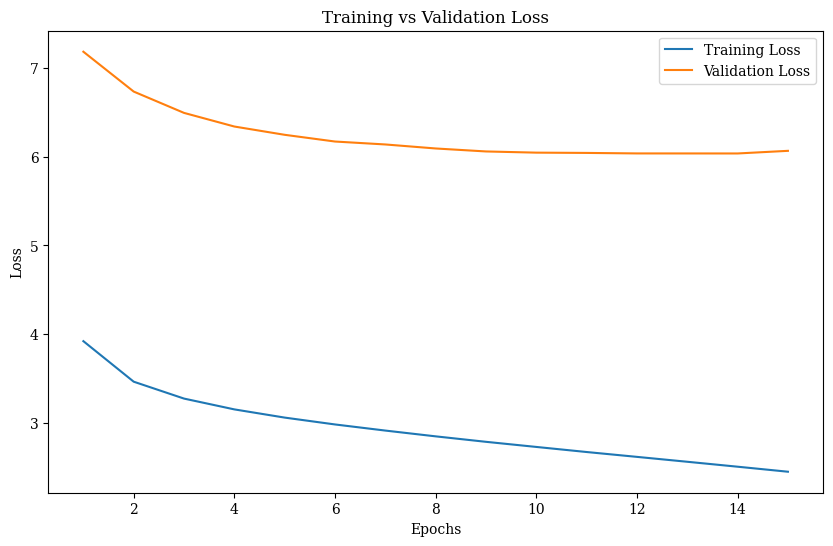

In [ ]:
import matplotlib.pyplot as plt

# Creating the plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.savefig(f"results/{model_save_name}.png", dpi=300)
plt.show()

### Testing

In [14]:
model_save_name = "M_limited_dataset_bs16_es512_ffn2048_nh4_nl4_tknzrbpe_fdsFalse"

In [15]:
model_save_name

'M_limited_dataset_bs16_es512_ffn2048_nh4_nl4_tknzrbpe_fdsFalse'

In [25]:
epoch_checkpoint = 12
transformer = torch.load(f"models/e{epoch_checkpoint}_{model_save_name}.pt")
with open(f'tokenizers/{model_save_name}_tokenizer.pkl', 'rb') as file:
    tokenizer = pickle.load(file)

In [26]:
total_params = sum(p.numel() for p in transformer.parameters())
print(f"Total number of parameters: {total_params}")

trainable_params = sum(p.numel() for p in transformer.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {trainable_params}")

Total number of parameters: 75537712
Total number of trainable parameters: 75537712


In [29]:
def flatten_scores(rouge_scores):
    flattened_scores = {f"{main_key}-{sub_key}": sub_value
                    for main_key, sub_dict in rouge_scores.items()
                    for sub_key, sub_value in sub_dict.items()}
    return flattened_scores

def get_test_scores_for_model(
    model,
    model_tag,
    test_articles,
    test_summaries,
    tokenizer
):
    """
    Function to evaluate a model on the test set. ROUGE scores are calculated across the entire test set.
    """
    rouge = PyRouge(rouge_n=(1, 2, 4), rouge_l=True, rouge_w=True, rouge_s=True, rouge_su=True)

    decoding_methods = [
        'greedy',
        'beam_search',
        'top_k',
        # 'top_p',
        'random_sampling'
    ]
    decoding_methods_to_scores = {}

    for decoding_method in decoding_methods:
        print(f"Generating summaries using {decoding_method} method.")
        generated_summaries = []
        for i, test_article in enumerate(tqdm(test_articles, desc=f'Generating summaries with {decoding_method} method.')):
            generated_summary = summarize(model, test_article, tokenizer=tokenizer, decoding_method=decoding_method, max_len=100)
            generated_summaries.append(generated_summary)

        print(f'Calculating ROUGE scores for {decoding_method} method.\n')
        scores = rouge.evaluate(generated_summaries, [[x] for x in test_summaries])
        flattened_scores = flatten_scores(scores)
        decoding_methods_to_scores[f"{decoding_method}_{model_tag}"] = flattened_scores
        print(flattened_scores)
        print()

    return decoding_methods_to_scores


In [31]:
tmptmp = get_test_scores_for_model(transformer, model_save_name, test_articles, test_summaries, tokenizer)

Generating summaries using greedy method.


Generating summaries with greedy method.: 100%|██████████| 1000/1000 [06:48<00:00,  2.45it/s]


Calculating ROUGE scores for greedy method.

{'rouge-1-r': 0.18709510265912108, 'rouge-1-p': 0.20669670427644607, 'rouge-1-f': 0.19640805331549843, 'rouge-2-r': 0.018772406558233815, 'rouge-2-p': 0.020926932985993678, 'rouge-2-f': 0.0197912055233226, 'rouge-4-r': 0.0005038280265652444, 'rouge-4-p': 0.0005942260650355835, 'rouge-4-f': 0.0005453060062715818, 'rouge-l-r': 0.14196865222445018, 'rouge-l-p': 0.15489710155914863, 'rouge-l-f': 0.1481513610886635, 'rouge-w-1.2-r': 0.04844413877718998, 'rouge-w-1.2-p': 0.11398932595107089, 'rouge-w-1.2-f': 0.06799232824012108, 'rouge-s*-r': 0.03258890465284137, 'rouge-s*-p': 0.04257247172797219, 'rouge-s*-f': 0.036917637456485686, 'rouge-su*-r': 0.03813439411225379, 'rouge-su*-p': 0.0488060452044732, 'rouge-su*-f': 0.042815264737908226}

Generating summaries using top_k method.


Generating summaries with top_k method.: 100%|██████████| 1000/1000 [07:07<00:00,  2.34it/s]


Calculating ROUGE scores for top_k method.

{'rouge-1-r': 0.20178784792416365, 'rouge-1-p': 0.21688541626598704, 'rouge-1-f': 0.20906441914367405, 'rouge-2-r': 0.019101383454799458, 'rouge-2-p': 0.021005957799837757, 'rouge-2-f': 0.020008449436854394, 'rouge-4-r': 0.0003212755639985521, 'rouge-4-p': 0.0003000055281034647, 'rouge-4-f': 0.0003102764480342415, 'rouge-l-r': 0.1409874514853267, 'rouge-l-p': 0.14939433694424514, 'rouge-l-f': 0.1450691997319783, 'rouge-w-1.2-r': 0.04810795808112669, 'rouge-w-1.2-p': 0.11032341379059721, 'rouge-w-1.2-f': 0.06699978802559482, 'rouge-s*-r': 0.03678208159642264, 'rouge-s*-p': 0.044842484642138705, 'rouge-s*-f': 0.04041430184811837, 'rouge-su*-r': 0.04270422302329352, 'rouge-su*-p': 0.0513439552785733, 'rouge-su*-f': 0.046627244816515076}

Generating summaries using random_sampling method.


Generating summaries with random_sampling method.: 100%|██████████| 1000/1000 [06:37<00:00,  2.51it/s]


Calculating ROUGE scores for random_sampling method.

{'rouge-1-r': 0.1879989196474506, 'rouge-1-p': 0.21436455588619382, 'rouge-1-f': 0.20031790839792663, 'rouge-2-r': 0.015228513597677257, 'rouge-2-p': 0.018149509180053935, 'rouge-2-f': 0.016561199516228902, 'rouge-4-r': 0.00017380263825155979, 'rouge-4-p': 0.00022570612345048434, 'rouge-4-f': 0.00019638277547706512, 'rouge-l-r': 0.13327875703158643, 'rouge-l-p': 0.15110277283897772, 'rouge-l-f': 0.14163219219737125, 'rouge-w-1.2-r': 0.04569462541091078, 'rouge-w-1.2-p': 0.112131598627167, 'rouge-w-1.2-f': 0.06492978498628722, 'rouge-s*-r': 0.03135500964410521, 'rouge-s*-p': 0.042338977935028575, 'rouge-s*-f': 0.03602842253715328, 'rouge-su*-r': 0.036952259004287585, 'rouge-su*-p': 0.04917880693871636, 'rouge-su*-f': 0.04219773647579968}



In [24]:
tmptmp = get_test_scores_for_model(transformer, model_save_name, test_articles[:50], test_summaries[:50], tokenizer)

Generating summaries using greedy method.


Generating summaries with greedy method.: 100%|██████████| 50/50 [00:15<00:00,  3.28it/s]


Calculating ROUGE scores for greedy method.

{'rouge-1-r': 0.12302696004570475, 'rouge-1-p': 0.17427535288685408, 'rouge-1-f': 0.1442341074650553, 'rouge-2-r': 0.009102584800554226, 'rouge-2-p': 0.013291542222650958, 'rouge-2-f': 0.010805278552404218, 'rouge-4-r': 0.0, 'rouge-4-p': 0.0, 'rouge-4-f': 0.0, 'rouge-l-r': 0.11144366754778573, 'rouge-l-p': 0.154932953441908, 'rouge-l-f': 0.12963822794527155, 'rouge-w-1.2-r': 0.03951451582464999, 'rouge-w-1.2-p': 0.11847237579105116, 'rouge-w-1.2-f': 0.05926287326883673, 'rouge-s*-r': 0.01650359907397503, 'rouge-s*-p': 0.032613364799418794, 'rouge-s*-f': 0.02191657849578345, 'rouge-su*-r': 0.02024795411351207, 'rouge-su*-p': 0.03973561877944939, 'rouge-su*-f': 0.02682617746542098}



In [20]:
tmptmp = get_test_scores_for_model(transformer, model_save_name, test_articles[:50], test_summaries[:50], tokenizer)

Generating summaries using greedy method.


Generating summaries with greedy method.: 100%|██████████| 50/50 [00:22<00:00,  2.26it/s]


Calculating ROUGE scores for greedy method.

{'rouge-1-r': 0.16753567507018371, 'rouge-1-p': 0.19936788257777083, 'rouge-1-f': 0.1820709126349141, 'rouge-2-r': 0.014682601920255238, 'rouge-2-p': 0.01937464574921555, 'rouge-2-f': 0.016705413992493513, 'rouge-4-r': 0.0004, 'rouge-4-p': 0.0006666666666666666, 'rouge-4-f': 0.0005, 'rouge-l-r': 0.14009919450465322, 'rouge-l-p': 0.1658315028542655, 'rouge-l-f': 0.15188315637460756, 'rouge-w-1.2-r': 0.04818777629048514, 'rouge-w-1.2-p': 0.12240694245485391, 'rouge-w-1.2-f': 0.06915241459757025, 'rouge-s*-r': 0.027905039925877527, 'rouge-s*-p': 0.04287807304966667, 'rouge-s*-f': 0.03380790389394265, 'rouge-su*-r': 0.03291021511211397, 'rouge-su*-p': 0.0492329940604008, 'rouge-su*-f': 0.03944984476412114}

Generating summaries using top_k method.


Generating summaries with top_k method.: 100%|██████████| 50/50 [00:19<00:00,  2.51it/s]


Calculating ROUGE scores for top_k method.

{'rouge-1-r': 0.18319645378504165, 'rouge-1-p': 0.21936644605554378, 'rouge-1-f': 0.19965652578872686, 'rouge-2-r': 0.018548964419592556, 'rouge-2-p': 0.02545394602420467, 'rouge-2-f': 0.021459686842498694, 'rouge-4-r': 0.0, 'rouge-4-p': 0.0, 'rouge-4-f': 0.0, 'rouge-l-r': 0.13530189852888092, 'rouge-l-p': 0.16277907837835112, 'rouge-l-f': 0.14777406175924315, 'rouge-w-1.2-r': 0.04691899879396648, 'rouge-w-1.2-p': 0.12239839384760268, 'rouge-w-1.2-f': 0.06783485150254064, 'rouge-s*-r': 0.0301351908751001, 'rouge-s*-p': 0.04568148854688858, 'rouge-s*-f': 0.03631444656543302, 'rouge-su*-r': 0.03562473367625408, 'rouge-su*-p': 0.05317363740430164, 'rouge-su*-f': 0.04266512207543736}

Generating summaries using random_sampling method.


Generating summaries with random_sampling method.: 100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


Calculating ROUGE scores for random_sampling method.

{'rouge-1-r': 0.17740015134058573, 'rouge-1-p': 0.21784161706714555, 'rouge-1-f': 0.19555188203754434, 'rouge-2-r': 0.012571533430795853, 'rouge-2-p': 0.016209519695733775, 'rouge-2-f': 0.01416060196659192, 'rouge-4-r': 0.00037037037037037035, 'rouge-4-p': 0.000392156862745098, 'rouge-4-f': 0.00038095238095238096, 'rouge-l-r': 0.12669933255506569, 'rouge-l-p': 0.15650616868610281, 'rouge-l-f': 0.14003419443744372, 'rouge-w-1.2-r': 0.044450102208488135, 'rouge-w-1.2-p': 0.11902331178164301, 'rouge-w-1.2-f': 0.06472732470377322, 'rouge-s*-r': 0.026798527236774245, 'rouge-s*-p': 0.04150460538654561, 'rouge-s*-f': 0.03256841246321297, 'rouge-su*-r': 0.03222865093329778, 'rouge-su*-p': 0.049335202776641156, 'rouge-su*-f': 0.038988031013499826}



In [ ]:
tmptmp = get_test_scores_for_model(transformer, model_save_name, test_articles[:5], test_summaries[:5], tokenizer)

Generating summaries using greedy method.


Generating summaries with greedy method.: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


Calculating ROUGE scores for greedy method.

{'rouge-1-r': 0.21550121250666257, 'rouge-1-p': 0.19706308726188015, 'rouge-1-f': 0.20587013597185458, 'rouge-2-r': 0.026130268199233718, 'rouge-2-p': 0.028053221288515406, 'rouge-2-f': 0.027057622277616517, 'rouge-4-r': 0.0035714285714285713, 'rouge-4-p': 0.0037037037037037034, 'rouge-4-f': 0.0036363636363636364, 'rouge-l-r': 0.13618536171814638, 'rouge-l-p': 0.11975558073519496, 'rouge-l-f': 0.12744312749541722, 'rouge-w-1.2-r': 0.04515810530541877, 'rouge-w-1.2-p': 0.08829133377428364, 'rouge-w-1.2-f': 0.05975400684529979, 'rouge-s*-r': 0.04360517412929871, 'rouge-s*-p': 0.04415543817425159, 'rouge-s*-f': 0.043878581058300864, 'rouge-su*-r': 0.04905507746252709, 'rouge-su*-p': 0.048598522602416615, 'rouge-su*-f': 0.04882573277872928}

Generating summaries using top_k method.


Generating summaries with top_k method.: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Calculating ROUGE scores for top_k method.

{'rouge-1-r': 0.26016567439920346, 'rouge-1-p': 0.22084136716637529, 'rouge-1-f': 0.2388960587232854, 'rouge-2-r': 0.053793103448275856, 'rouge-2-p': 0.044195369847543756, 'rouge-2-f': 0.048524199269163584, 'rouge-4-r': 0.0, 'rouge-4-p': 0.0, 'rouge-4-f': 0.0, 'rouge-l-r': 0.17513366103926364, 'rouge-l-p': 0.1480243644025976, 'rouge-l-f': 0.16044193131450435, 'rouge-w-1.2-r': 0.05716989011033994, 'rouge-w-1.2-p': 0.10844419389243667, 'rouge-w-1.2-f': 0.07486975138939343, 'rouge-s*-r': 0.06475807723525376, 'rouge-s*-p': 0.04684599630151838, 'rouge-s*-f': 0.054364622195561485, 'rouge-su*-r': 0.07105399964962007, 'rouge-su*-p': 0.051649558832405774, 'rouge-su*-f': 0.05981746219231898}

Generating summaries using random_sampling method.


Generating summaries with random_sampling method.: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]

Calculating ROUGE scores for random_sampling method.

{'rouge-1-r': 0.2383585326216931, 'rouge-1-p': 0.18961919112585685, 'rouge-1-f': 0.211213573257528, 'rouge-2-r': 0.04078544061302682, 'rouge-2-p': 0.03294520122878332, 'rouge-2-f': 0.03644847012409439, 'rouge-4-r': 0.0, 'rouge-4-p': 0.0, 'rouge-4-f': 0.0, 'rouge-l-r': 0.1808628796127763, 'rouge-l-p': 0.1431682858429561, 'rouge-l-f': 0.1598230738723162, 'rouge-w-1.2-r': 0.057587281417454436, 'rouge-w-1.2-p': 0.10107945567622852, 'rouge-w-1.2-f': 0.0733725438131775, 'rouge-s*-r': 0.054048582427219105, 'rouge-s*-p': 0.03624862983994478, 'rouge-s*-f': 0.043394187009479966, 'rouge-su*-r': 0.05994866318298989, 'rouge-su*-p': 0.040065444334686354, 'rouge-su*-f': 0.048030620625644074}



In [ ]:
decoding_methods_to_scores = get_test_scores_for_model(transformer, model_save_name, test_articles, test_summaries, tokenizer)

Generating summaries using greedy method.


Generating summaries with greedy method.: 100%|██████████| 1000/1000 [03:10<00:00,  5.25it/s]


Calculating ROUGE scores for greedy method.

{'rouge-1-r': 0.17612388150029973, 'rouge-1-p': 0.22605554387297794, 'rouge-1-f': 0.1979901372857029, 'rouge-2-r': 0.017848394320596723, 'rouge-2-p': 0.023934739576689852, 'rouge-2-f': 0.02044828283946864, 'rouge-4-r': 0.0008186014076561537, 'rouge-4-p': 0.0009512278724149314, 'rouge-4-f': 0.0008799452965648251, 'rouge-l-r': 0.138891826843011, 'rouge-l-p': 0.17584252967897104, 'rouge-l-f': 0.15519811979664117, 'rouge-w-1.2-r': 0.04747574020122226, 'rouge-w-1.2-p': 0.12970817478243893, 'rouge-w-1.2-f': 0.06950960089705266, 'rouge-s*-r': 0.029805439042387645, 'rouge-s*-p': 0.053827930440603584, 'rouge-s*-f': 0.038366625892110616, 'rouge-su*-r': 0.034999855501934664, 'rouge-su*-p': 0.06125509906639896, 'rouge-su*-f': 0.04454668594869344}

Generating summaries using beam_search method.


Generating summaries with beam_search method.: 100%|██████████| 1000/1000 [33:25<00:00,  2.01s/it]


Calculating ROUGE scores for beam_search method.

{'rouge-1-r': 0.13785286472375316, 'rouge-1-p': 0.22718415563864183, 'rouge-1-f': 0.17158800301154367, 'rouge-2-r': 0.01454086352934745, 'rouge-2-p': 0.023204309557946227, 'rouge-2-f': 0.017878349520056264, 'rouge-4-r': 0.0008523458897226671, 'rouge-4-p': 0.001298790638532868, 'rouge-4-f': 0.0010292409131850923, 'rouge-l-r': 0.10973466215990509, 'rouge-l-p': 0.18380320732914893, 'rouge-l-f': 0.137424059766321, 'rouge-w-1.2-r': 0.03853215939594364, 'rouge-w-1.2-p': 0.14378903482190492, 'rouge-w-1.2-f': 0.06077737734129142, 'rouge-s*-r': 0.020744573688142837, 'rouge-s*-p': 0.05122807498714081, 'rouge-s*-f': 0.029530789710602832, 'rouge-su*-r': 0.024844711659023553, 'rouge-su*-p': 0.06220184933792689, 'rouge-su*-f': 0.03550713534824102}

Generating summaries using top_k method.


Generating summaries with top_k method.: 100%|██████████| 1000/1000 [03:46<00:00,  4.42it/s]


Calculating ROUGE scores for top_k method.

{'rouge-1-r': 0.20111351159554536, 'rouge-1-p': 0.24040090057339622, 'rouge-1-f': 0.21900924623292878, 'rouge-2-r': 0.020893779663583946, 'rouge-2-p': 0.0257590299708907, 'rouge-2-f': 0.023072715267366605, 'rouge-4-r': 0.00040666179381623746, 'rouge-4-p': 0.0005948689600102734, 'rouge-4-f': 0.0004830814779059338, 'rouge-l-r': 0.14275298272699222, 'rouge-l-p': 0.1683590579415964, 'rouge-l-f': 0.15450226637722003, 'rouge-w-1.2-r': 0.04879002575036257, 'rouge-w-1.2-p': 0.12409296472265677, 'rouge-w-1.2-f': 0.07004158046655425, 'rouge-s*-r': 0.03667370024832909, 'rouge-s*-p': 0.05560368103459025, 'rouge-s*-f': 0.044197022122120434, 'rouge-su*-r': 0.04260785030523386, 'rouge-su*-p': 0.06319111708954714, 'rouge-su*-f': 0.05089723886482367}

Generating summaries using random_sampling method.


Generating summaries with random_sampling method.: 100%|██████████| 1000/1000 [03:31<00:00,  4.73it/s]


Calculating ROUGE scores for random_sampling method.

{'rouge-1-r': 0.18890196480749277, 'rouge-1-p': 0.22828168113212496, 'rouge-1-f': 0.2067332145692857, 'rouge-2-r': 0.016652188324084535, 'rouge-2-p': 0.01995824132620792, 'rouge-2-f': 0.018155940607972956, 'rouge-4-r': 0.00019956884652911637, 'rouge-4-p': 0.0001938124851216404, 'rouge-4-f': 0.00019664854931655164, 'rouge-l-r': 0.13496565720776443, 'rouge-l-p': 0.1623295932633024, 'rouge-l-f': 0.1473882963440272, 'rouge-w-1.2-r': 0.046336375526360246, 'rouge-w-1.2-p': 0.12026622788507757, 'rouge-w-1.2-f': 0.06689812745194099, 'rouge-s*-r': 0.031970158149254226, 'rouge-s*-p': 0.04825889837891194, 'rouge-s*-f': 0.03846099356137769, 'rouge-su*-r': 0.03760203002505486, 'rouge-su*-p': 0.05567786666336683, 'rouge-su*-f': 0.044888574887686127}



In [33]:
decoding_methods_to_scores_df = pd.DataFrame.from_dict(decoding_methods_to_scores, orient='index')

In [34]:
decoding_methods_to_scores_df

,rouge-1-r,rouge-1-p,rouge-1-f,rouge-2-r,rouge-2-p,rouge-2-f,rouge-4-r,rouge-4-p,rouge-4-f,rouge-l-r,...,rouge-l-f,rouge-w-1.2-r,rouge-w-1.2-p,rouge-w-1.2-f,rouge-s*-r,rouge-s*-p,rouge-s*-f,rouge-su*-r,rouge-su*-p,rouge-su*-f
greedy_M_limited_dataset_bs16_es512_ffn2048_nh4_nl4_tknzrbpe_fdsFalse,0.187095,0.206697,0.196408,0.018772,0.020927,0.019791,0.000504,0.000594,0.000545,0.141969,...,0.148151,0.048444,0.113989,0.067992,0.032589,0.042572,0.036918,0.038134,0.048806,0.042815
top_k_M_limited_dataset_bs16_es512_ffn2048_nh4_nl4_tknzrbpe_fdsFalse,0.201788,0.216885,0.209064,0.019101,0.021006,0.020008,0.000321,0.000300,0.000310,0.140987,...,0.145069,0.048108,0.110323,0.067000,0.036782,0.044842,0.040414,0.042704,0.051344,0.046627
random_sampling_M_limited_dataset_bs16_es512_ffn2048_nh4_nl4_tknzrbpe_fdsFalse,0.187999,0.214365,0.200318,0.015229,0.018150,0.016561,0.000174,0.000226,0.000196,0.133279,...,0.141632,0.045695,0.112132,0.064930,0.031355,0.042339,0.036028,0.036952,0.049179,0.042198


In [35]:
file_path = 'results/final_results.csv'

if os.path.exists(file_path):
    existing_df = pd.read_csv(file_path)
    final_df = existing_df.append(decoding_methods_to_scores_df, ignore_index=False)
else:
    final_df = decoding_methods_to_scores_df

final_df.to_csv(file_path, index=True)

<ipython-input-35-4d75cb6c56e9>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = existing_df.append(decoding_methods_to_scores_df, ignore_index=False)


In [ ]:
for i, (article, summary) in enumerate(zip(test_articles[700:720], test_summaries[700:720])):
    generated_summary = summarize(transformer, article, tokenizer=tokenizer, decoding_method='top_k')
    print(f'**Input article no.{i}**: {article}')
    print(f'**Gold label summary**: {summary}')
    print(f'**Generated summary**: {generated_summary}\n\n')

# XXS_full_dataset_bs8_es256_nh2_nl2_tknzrbpe


**Input article no.0**: AP McCoy has urged the nation to follow his Aintree dream as he chases the fairytale end to his extraordinary career. Retirement beckons for McCoy, champion jockey every year since he first won the title in 1997, and he will stop riding immediately if his mount Shutthefrontdoor wins the £1million Crabbie’s Grand National on Saturday. AP McCoy celebrates Grand National victory on Don’t Push It in 2010 . Shutthefrontdoor, trained by Jonjo O’Neill, will be the subject of an avalanche of emotional support and many once-a-year punters will pin their hopes on McCoy delivering a result like he did in 2010 when he won this famous race on Don’t Push It. In a perfect world, the National will finish with McCoy standing high in his irons celebrating but he, more than anyone, knows nothing is guaranteed in a sport as unpredictable as jump racing. It won’t, however, stop the 40-year-old hoping his script has a glorious finale. ‘I’m a dreamer,’ said McCoy, who announced his pl

In [ ]:
for i, (article, summary) in enumerate(zip(test_articles[700:720], test_summaries[700:720])):
    generated_summary = summarize(transformer, article, tokenizer=tokenizer, decoding_method='top_k')
    print(f'**Input article no.{i}**: {article}')
    print(f'**Gold label summary**: {summary}')
    print(f'**Generated summary**: {generated_summary}\n\n')

    # "M_full_dataset_bs32_es512_nh8_nl6_tknzrbpe"

**Input article no.0**: AP McCoy has urged the nation to follow his Aintree dream as he chases the fairytale end to his extraordinary career. Retirement beckons for McCoy, champion jockey every year since he first won the title in 1997, and he will stop riding immediately if his mount Shutthefrontdoor wins the £1million Crabbie’s Grand National on Saturday. AP McCoy celebrates Grand National victory on Don’t Push It in 2010 . Shutthefrontdoor, trained by Jonjo O’Neill, will be the subject of an avalanche of emotional support and many once-a-year punters will pin their hopes on McCoy delivering a result like he did in 2010 when he won this famous race on Don’t Push It. In a perfect world, the National will finish with McCoy standing high in his irons celebrating but he, more than anyone, knows nothing is guaranteed in a sport as unpredictable as jump racing. It won’t, however, stop the 40-year-old hoping his script has a glorious finale. ‘I’m a dreamer,’ said McCoy, who announced his pl

### Old Testing

In [ ]:
for test_article in test_articles[:10]:

    summary = summarize(transformer, test_article, decoding_method='greedy')
    print(test_article)
    print(summary, end='\n\n')

The mother and daughter who survived a tragic car accident this week, which saw three children die, have been reunited. Aluel Manyang was moved from the intensive care unit at the Royal Children's about 5.15pm on Friday, and greeted her distraught mother, Akon Goode, with a 'big hug', her father said. 'She didn't believe that her mum was still alive,' Joseph Manyang said, according to the Herald Sun. Scroll down for videos . Aueel Manyang, pictured here as a baby with her mother Akon Guode, believes her three siblings who died in the crash at a Melbourne lake were eaten by crocodiles in the water . Ms Guode visited her daughter for the first time but did not stay the night in the hospital. Mr Manyang said his daughter was expected to make a '100 per cent' recovery and she should be allowed to go home within four days. The five-year-old girl who survived when a car driven by her mother plunged into a lake believes her three siblings who died in the crash were eaten by crocodiles. Aluel 

### Misc Testing